In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from math import sqrt
from matplotlib import pyplot
import numpy


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [2]:
series = read_csv('../data/new_single_cluster_0.csv', usecols=[1], engine='python')
series00 = read_csv('../data/new_single_cluster_00.csv', usecols=[1], engine='python')
series000 = read_csv('../data/new_single_cluster_000.csv', usecols=[1], engine='python')
series0000 = read_csv('../data/new_single_cluster_0000.csv', usecols=[1], engine='python')
series00000 = read_csv('../data/new_single_cluster_00000.csv', usecols=[1], engine='python')

# transform data to be stationary
raw_values = series.values
raw_values00 = series00.values
raw_values000 = series000.values
raw_values0000 = series0000.values
raw_values00000 = series00000.values

In [3]:
series2 = read_csv('../data/new_single_cluster_1.csv', usecols=[1], engine='python')
series22 = read_csv('../data/new_single_cluster_11.csv', usecols=[1], engine='python')
series222 = read_csv('../data/new_single_cluster_111.csv', usecols=[1], engine='python')
series2222 = read_csv('../data/new_single_cluster_1111.csv', usecols=[1], engine='python')
series22222 = read_csv('../data/new_single_cluster_1111.csv', usecols=[1], engine='python')


# transform data to be stationary
raw_values2 = series2.values
raw_values22 = series22.values
raw_values222 = series222.values
raw_values2222 = series2222.values
raw_values22222 = series22222.values


In [4]:
series3 = read_csv('../data/new_single_cluster_2.csv', usecols=[1], engine='python')
series33 = read_csv('../data/new_single_cluster_22.csv', usecols=[1], engine='python')
series333 = read_csv('../data/new_single_cluster_222.csv', usecols=[1], engine='python')
series3333 = read_csv('../data/new_single_cluster_2222.csv', usecols=[1], engine='python')
series33333 = read_csv('../data/new_single_cluster_22222.csv', usecols=[1], engine='python')


# transform data to be stationary
raw_values3 = series3.values
raw_values33 = series33.values
raw_values333 = series333.values
raw_values3333 = series3333.values
raw_values33333 = series33333.values

In [5]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [6]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [7]:


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons, validation_split=0.02, patience=3):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')

	history = {'loss': [], 'val_loss': []}
	early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)

    
	for i in range(nb_epoch):
		hist = model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, validation_split=validation_split, callbacks=[early_stopping])
		history['loss'].append(hist.history['loss'][0])
		history['val_loss'].append(hist.history['val_loss'][0])
		model.reset_states()
    
	return model, history

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [8]:
### Global Variables
NB_EPOCH = 10
NEURONS = 32
BATCH_SIZE = 1
TEST_SIZE = -3

In [9]:
test_total = []

In [10]:
def train(value):
	diff_values = difference(value, 1)

	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values

	# split data into train and test-sets
	train, test = supervised_values[0:TEST_SIZE], supervised_values[TEST_SIZE:]

	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)

	# fit the model
	lstm_model, history = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)

	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(value, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
		expected = value[len(train) + i + 1]
		print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


	# report performance
	rmse = sqrt(mean_squared_error(value[TEST_SIZE:], predictions))
	print('Test RMSE: %.3f' % rmse)
	test_total.append(rmse)

	mae = mean_absolute_error(value[TEST_SIZE:], predictions)
	print('Test MAE: %.3f' % mae)
	# line plot of observed vs predicted
	pyplot.plot(raw_values[TEST_SIZE:])
	pyplot.plot(predictions)
	pyplot.show()

	pyplot.plot(history['loss'])
	pyplot.plot(history['val_loss'])
	pyplot.show()

### For Cluster 0

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=1914.650121, Expected=2100.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=2191.465777, Expected=2350.000000
1/1 [==============================] - 0s 15ms/step
Month=3, Predicted=2427.191051, Expected=2250.000000
Test RMSE: 174.054
Test MAE: 173.692


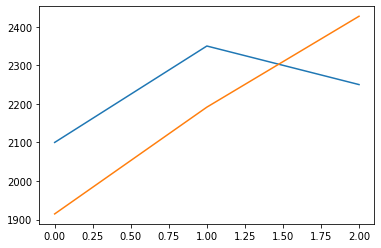

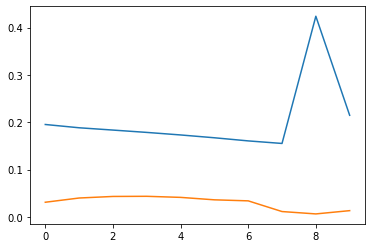

In [11]:
train(raw_values)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=1812.743610, Expected=2133.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=2121.996074, Expected=2328.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=2302.168085, Expected=2431.000000
Test RMSE: 232.092
Test MAE: 218.364


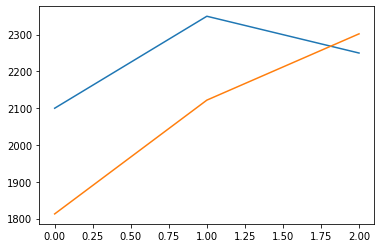

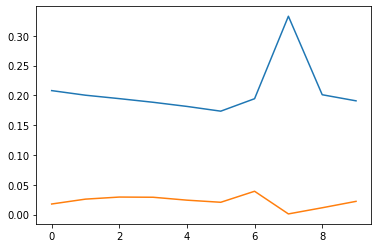

In [12]:
train(raw_values00)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=1802.022225, Expected=2126.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=2064.231691, Expected=2305.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=2195.195961, Expected=2489.000000
Test RMSE: 288.243
Test MAE: 286.183


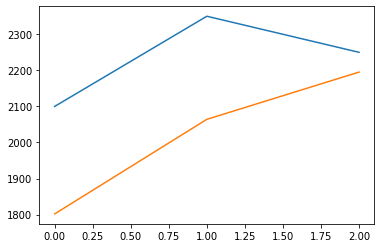

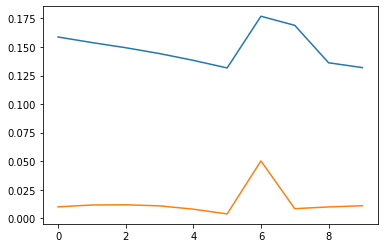

In [13]:
train(raw_values000)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=1679.228963, Expected=2188.000000
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=2112.168763, Expected=2375.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=2262.315181, Expected=2429.000000
Test RMSE: 344.341
Test MAE: 312.762


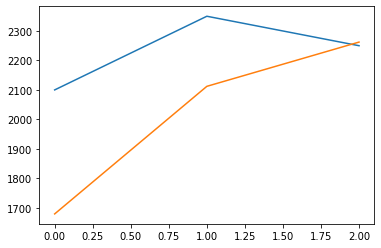

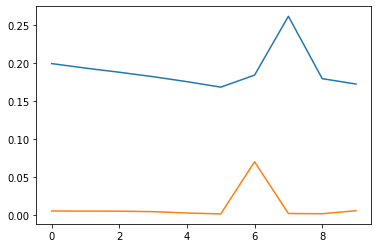

In [14]:
train(raw_values0000)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=1808.974711, Expected=2146.000000
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=2040.092176, Expected=2347.000000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=2161.350450, Expected=2456.000000
Test RMSE: 313.367
Test MAE: 312.861


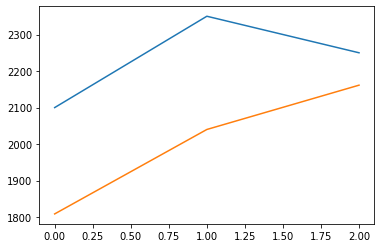

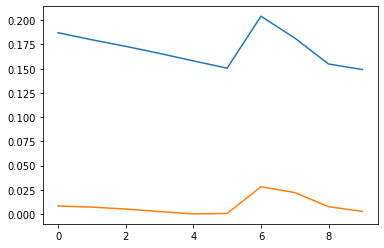

In [15]:
train(raw_values00000)

In [16]:
mean = sum(test_total) / len(test_total)

print("Mean:", mean)

Mean: 270.4192733691711


### For Cluster 1

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=1465.544327, Expected=1933.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=1825.691014, Expected=2028.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=1884.709795, Expected=2111.000000
Test RMSE: 321.792
Test MAE: 298.685


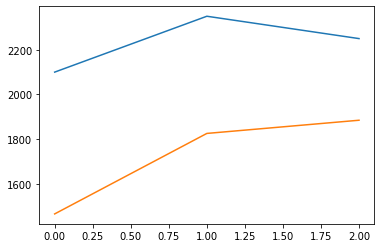

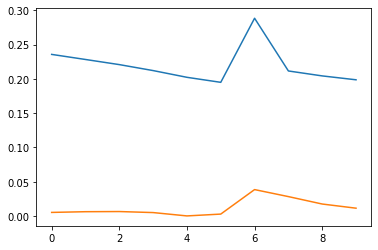

In [17]:
train(raw_values2)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=1634.282503, Expected=1926.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=1889.057427, Expected=2105.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=2012.254487, Expected=2089.000000
Test RMSE: 214.181
Test MAE: 194.802


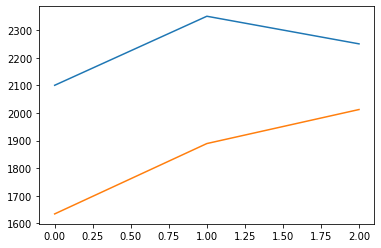

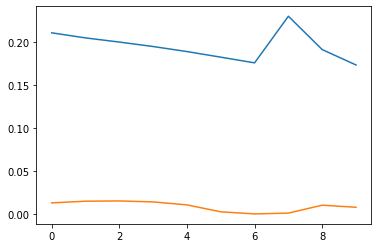

In [18]:
train(raw_values22)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=1664.248847, Expected=1988.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=1888.219305, Expected=2075.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=1914.630286, Expected=2109.000000
Test RMSE: 243.229
Test MAE: 234.967


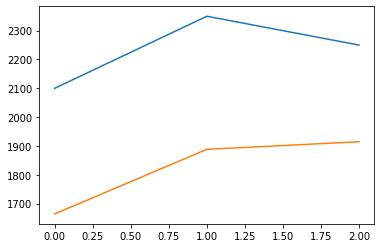

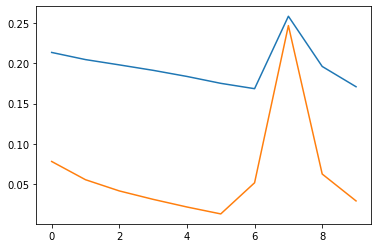

In [19]:
train(raw_values222)

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=1683.196062, Expected=2146.000000
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=2053.294181, Expected=2077.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=2025.960431, Expected=2056.000000
Test RMSE: 268.112
Test MAE: 172.183


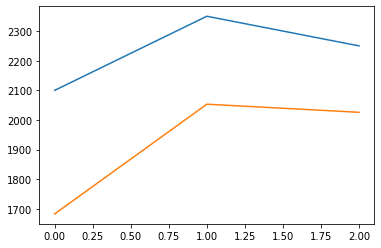

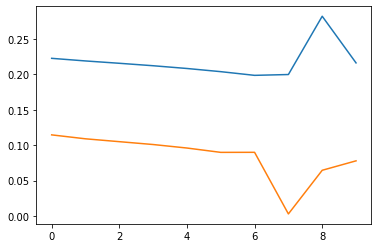

In [20]:
train(raw_values2222)

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=1587.980321, Expected=2146.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=1970.355315, Expected=2077.000000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=1936.597850, Expected=2056.000000
Test RMSE: 335.170
Test MAE: 261.356


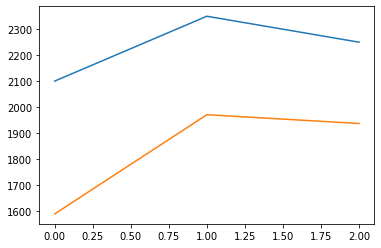

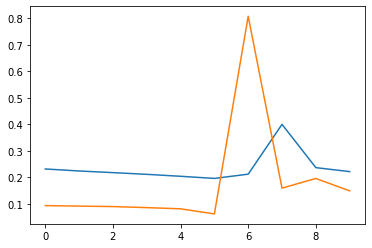

In [21]:
train(raw_values22222)

### For Cluster 2

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=2027.122760, Expected=2633.000000
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=2586.053451, Expected=2798.000000
1/1 [==============================] - 0s 14ms/step
Month=3, Predicted=2674.373913, Expected=2711.000000
Test RMSE: 371.192
Test MAE: 284.817


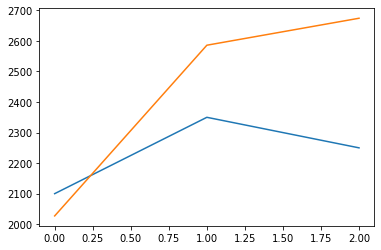

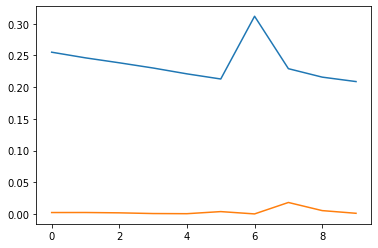

In [22]:
train(raw_values3)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=2100.479645, Expected=2646.000000
1/1 [==============================] - 0s 15ms/step
Month=2, Predicted=2616.093675, Expected=2785.000000
1/1 [==============================] - 0s 14ms/step
Month=3, Predicted=2694.613925, Expected=2889.000000
Test RMSE: 348.285
Test MAE: 302.938


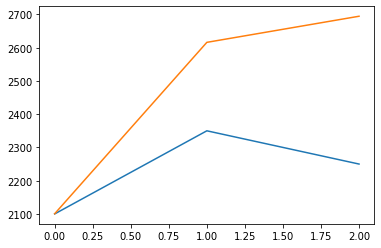

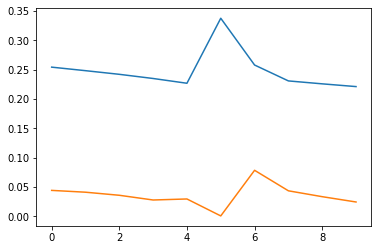

In [23]:
train(raw_values33)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=1814.111330, Expected=2775.000000
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=2272.645899, Expected=2784.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=2185.212390, Expected=2856.000000
Test RMSE: 738.184
Test MAE: 714.343


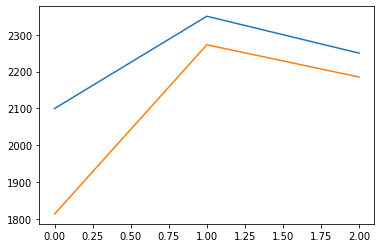

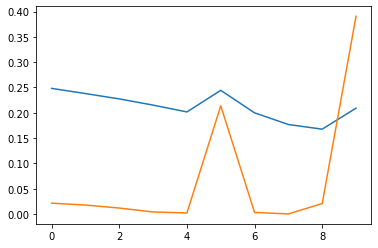

In [24]:
train(raw_values333)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=2122.801955, Expected=2761.000000
1/1 [==============================] - 0s 19ms/step
Month=2, Predicted=2644.736569, Expected=2752.000000
1/1 [==============================] - 0s 19ms/step
Month=3, Predicted=2583.922447, Expected=2881.000000
Test RMSE: 411.119
Test MAE: 347.513


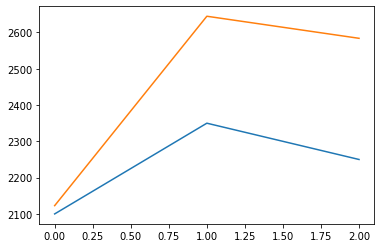

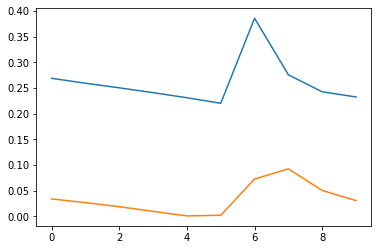

In [25]:
train(raw_values3333)

1/1 [==============================] - 0s 24ms/step
Month=1, Predicted=2187.670743, Expected=2785.000000
1/1 [==============================] - 0s 16ms/step
Month=2, Predicted=2740.081888, Expected=2794.000000
1/1 [==============================] - 0s 15ms/step
Month=3, Predicted=2641.408828, Expected=2872.000000
Test RMSE: 370.981
Test MAE: 293.946


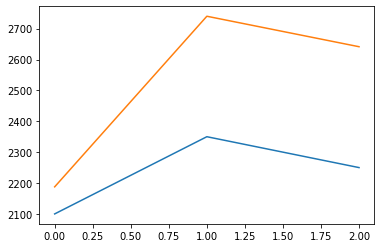

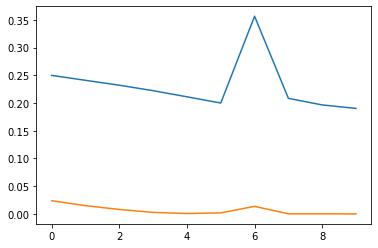

In [26]:
train(raw_values33333)